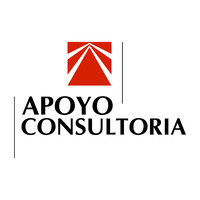

# ARIMA

Esta libreria construye la estimacion de los modelos ARIMA usando la metodologia especificada en el punto 2.1 del informe, mediante la metodología Box Jenkins.

Esta libreria realiza la estimacion, la proyeccion y la evaluación.


La expresión para un modelo ARMA(p,q):
$$y_t=c+\sum_{i=1}^p \alpha_i y_{t-i} + \epsilon_t+ \sum_{i=1}^q \beta_i \epsilon_{t-i}$$

Donde:

$y_t$: Serie modelada
$\epsilon_t$: Componente no predecible de la serie
$\alpha$: Parametros AR
$\beta$: Parametros MA

La estimación de estos modelos se realiza mediante Mínimos Cuadrados Ordinarios. Para la selección de los rezagos óptimos se usa la metodología de Box-Jenkins:

<ol> 
<li> Se elige el rezago óptimo (p,q) con el mejor criterio de información (AIC, BIC). Se estima el modelo. 
<li> Se observa la autocorrelación del error estimado. 
<li> Si se observa una autocorrelación significativa se agrega el rezago respectivo para corregirla. Se vuelve a estimar el modelo y se repite 2.
<li> El rezago óptimo es aquel que tienen el mejor criterio de información que elimina la autocorrelación en el error estimado.


### Librerias

In [1]:
#Importar librerias
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

import pandas as pd
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import matplotlib.pyplot as plt

from ipynb.fs.defs.ConstruccionBasedeDatos import BasedeDatos

In [2]:
rutaOrigen = 'inputs/'
rutaDestino = 'resultados/'
rutaModelos = 'model_nowcast/'


### Construcción de Base de datos

In [3]:
bd_mensual_t,bd_trimestral_t,bd_anual_t,bd_all = BasedeDatos(rutaOrigen + 'bd_Panama.xlsx')

C:\Users\eo\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\eo\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Funciones ARIMA

In [4]:
#Funcion de seleccion de mejor modelo, estimacion y proyeccion out sample

def nowcast_arima(serie,train_size,out=1):
    # Se dividen los datos en 2 submuestras: "train" y "test"
    bd_train = serie[:train_size]
    bd_test =  serie[train_size+1:]
    
    # Se define un modelo base ARIMA(3,0,3)
    model = ARIMA(bd_train, order=(3,0,3))
    model_fit = model.fit([0]*7,disp = 0)
   
    # Se definen modelos alternativos ARIMA(i,0,j), donde para i y j se iteran los valores 0,1,2.
    for i in range(4):
        for j in range(4):
            model_aux = ARIMA(serie.dropna(), order=(i,0,j))
            model_fit_aux = model_aux.fit([0]*(i+j+1),disp=0)
            # Se comparan el modelo base contra los modelos alternativos. Se selecciona el mejor modelo.
            if (model_fit_aux.bic < model_fit.bic) & (sum(sm.tsa.stattools.acf(model_fit_aux.resid.dropna(), qstat = True, nlags= 4)[2] < 0.1) == 0):
                model = model_aux
                model_fit = model_fit_aux
   
    # Se estiman predicciones
    predict = model_fit.predict(start = train_size-1, end = train_size + out)

    
    return predict

def eval_arima(serie):
    
    #Base de proyecciones
    prj_pib = pd.DataFrame()

    for train_size in range(30,len(serie)):

        prj_pib = pd.concat([prj_pib,nowcast_arima(serie,train_size)[1:2]], axis = 0)
        
    prj_pib = pd.concat([prj_pib,serie],axis=1)
    
    prj_pib.columns = ['EVAL_ARIMA','PIB_A']
    
    return prj_pib

################################################################


### Proyección ARIMA

C:\Users\eo\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


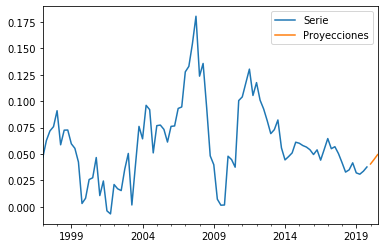

In [5]:
serie = bd_trimestral_t['pbif_Trimestre_VariacionAnual'].dropna()

serie.index = pd.DatetimeIndex(serie.index.values,
                               freq=serie.index.inferred_freq)

baseARIMA = pd.DataFrame()

#Base de proyecciones


baseARIMA.loc[:,'Serie'] = serie 
baseARIMA = baseARIMA.join(pd.DataFrame(nowcast_arima(serie,len(serie)+1),columns = ['Proyecciones']),how = 'outer')

baseARIMA.plot()
    
plt.show()

In [6]:
with pd.ExcelWriter(rutaDestino + 'baseARIMA.xlsx') as writer:
    baseARIMA.to_excel(writer, sheet_name='Proyecciones ARIMA')

### Evaluación de Proyecciones

In [7]:
eval_arima = eval_arima(serie)

C:\Users\eo\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\eo\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning
C:\Users\eo\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\eo\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


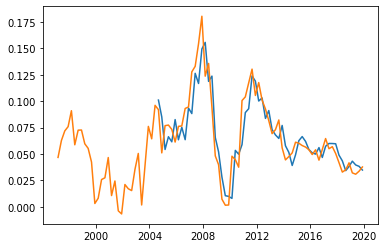

In [8]:
plt.plot(eval_arima)